### Author: Seth Cram
Class: Evolutionary Computation - CS472/CS572

Project 4

Due Date: Dec 9, 2022

Instructions:

You should read the page and familiarize yourself with the way the data
is formatted. Note that not all the data should be used when training your classifiers, you should select part of the data to be used to train your neural network/GP, part of the data should be reserved as a validation set.

Submission information:

You should construct a document where you describe your dataset, and how you had to modify or clean the dataset. You should describe the goal of the classification, why it is important, and what makes classifying the data challenging. Try to describe the search space, but note that in real world datasets, it isn't always obvious what range of values exist.

Describe your algorithms. Describe all methods you used to classify the data, and descriptions of any diversity techniques you use.

Plot and describe your results and any conclusions you can make from the results.

# Common Cells

## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#GP imports
import copy
from enum import Enum
import scipy.stats as ss
import anytree
from functools import reduce
import operator as OPER
import sklearn
import pickle
#NN+GA imports 
import keras 
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import applications
import random
from deepdiff import DeepDiff

print("modules imported")

modules imported


## Load Data

In [3]:
## load the alzheimers dataset
def load_data(test_split = 0.3, validation_split = 0.2):
    
    ## (1) Data preparation
    df=pd.read_csv('AlzData.csv', sep = ',')
    print(df)
    
    # rm ids, rm targets
    transposedDataFrameVals = df.values.T[1:-1].astype('float32')
    #walk thru features
    for i, row in enumerate(transposedDataFrameVals):
        #normalize data [0,1]
        transposedDataFrameVals[i] = row / max(row)
    
    #assign normalized data
    X = transposedDataFrameVals.T
    
    #assign targets
    targets = df.values.T[-1]
    #conv to binary target
    Y = np.array( [1 if target == 'P' else 0 for target in targets] )

    # data split of 70 training and 30 test
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split)
        
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


         ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0      id_1       5160     0.000013    120.804174       86.853334   
1      id_2      51980     0.000016    115.318238       83.448681   
2      id_3       2600     0.000010    229.933997      172.761858   
3      id_4       2130     0.000010    369.403342      183.193104   
4      id_5       2310     0.000007    257.997131      111.275889   
..      ...        ...          ...           ...             ...   
169  id_170       2930     0.000010    241.736477      176.115957   
170  id_171       2140     0.000009    274.728964      234.495802   
171  id_172       3830     0.000008    151.536989      171.104693   
172  id_173       1760     0.000008    289.518195      196.411138   
173  id_174       2875     0.000008    235.769350      178.208024   

     max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0                 957              6601          0.361800            0.217459   
1        

## Enum Types

In [5]:
class TestType(Enum):
    TRAINING = 0
    VALIDATION = 1
    TEST = 2

## Helper Functions

In [6]:
def save_object(obj, filePath) -> None:
    with open(filePath, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
def restore_object(filePath):
    with open(filePath, 'rb') as inp:
        obj = pickle.load(inp)
        
    return obj

# GP 

## Operators

In [ ]:
def IF(ops):
    conditional, trueRslt, falseRslt = ops[0], ops[1], ops[2]
    
    #print(f"if({conditional}) then {trueRslt} else {falseRslt}")
    
    if conditional:
        return trueRslt
    else:
        return falseRslt
 
def SUBTRACT(ops):
    #print(f"{ops[0]} - {ops[1]}")
    
    return reduce(OPER.sub, ops)

def MULTIPLY(ops):
    #print(f"{ops[0]} * {ops[1]}")
    
    return reduce(OPER.mul, ops)
    
def DIVIDE(ops):
    """Protected divison

    Args:
        ops (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    #print(f"{ops[0]} / {ops[1]}")
    
    if( ops[1] == 0):
        return 0
    else:
        return ops[0] / ops[1]
    
class Operator():
    def __init__(self, funct, arity) -> None:
        self.funct = funct
        self.arity = arity
        
    def __str__(self) -> str:
        return f"{self.funct}, arity {self.arity}"
    
    def __repr__(self) -> str:
        return f"{self.funct}, arity {self.arity}"
    


## Enum Types

In [ ]:
class InitType(Enum):
    GROWTH = 0
    FULL = 1
    
class NodeType(Enum):
    TERMINAL = 0
    NONTERMINAL = 1

## Individual Class

In [ ]:
class Individual():
    def __init__(self, initDepth: int, initType: InitType, NT: set, T: set, x, y, softCapNodeMax) -> None:
        #var init
        self.initType = initType
        self.initDepth = initDepth
        self.T = T
        self.NT = NT
        self.softCapNodeMax = softCapNodeMax
        
        assert len(x) == len(y)
        
        #funct init
        
        #initialize individual as tree
        self.nodeIndex = 0
        self.root = self.CreateNodeNT(self.nodeIndex, parent=None)
        self.CreateTreeRecursively(self.root)
        #print(anytree.RenderTree(self.root))
        
        assert self.nodeIndex == self.GetNodeCount() - 1
        #print(f"self node count = {self.nodeCount}, get node count = {self.GetNodeCount()}")
        
        #fitness eval of tree
        self.EvaluateFitness(x, y)
       
    def EvaluateFitness(self, x, y, applyParsimonyPressure = True):
        """
        Fitness evaluated through using RMSE (Root Mean Sqrd Error).
        Applies parsimony pressure by default.
        Lower fitness is better.
        """
        
        #predict the output given input
        y_pred = self.Predict(x)
        
        #sum up how many are wrong (more wrong, worse fitness)
        fitness = sum( y_pred != y )
        
        nodeCount = self.GetNodeCount()
            
        #if applying pressure and enough nodes to apply fitness mod
        if applyParsimonyPressure and nodeCount > self.softCapNodeMax:
            #incr fitness by every additional node over the max
            fitness = fitness * (nodeCount / self.softCapNodeMax)
            
        self.fitness = fitness
    
    def Predict(self, x) -> list:
        """Predict output given inputs.
        Averages outputs across each row.x_train
        Normalization performed if average not [0, 1]

        Args:
            x (_type_): _description_

        Returns:
            list: _description_
        """
        y_tree_pred = np.empty(x.shape)
        
        featureCount = x.shape[0]
        inputCount = x.shape[1]
        
        #walk down every col
        for j in range(featureCount):
            #walk across every row
            for i in range(inputCount):
                #NT's assigned values
                self.EvaluateFitnessRecursively(self.root, x[j][i])
                #store each input value's output
                y_tree_pred[j][i] = self.root.value
                
        #average outputs of tree for each row into a single output
        y_pred_prob = np.sum( y_tree_pred, axis=1) / inputCount
            
        #make sure each tree output is [0, 1]
        if (max( y_tree_pred.flatten() ) > 1.1 or
            min( y_tree_pred.flatten() < -0.1)):
            y_pred_prob = sklearn.preprocessing.minmax_scale(y_pred_prob, feature_range=(0, 1), axis=0, copy=True)
        
        #round outputs to binary output
        y_pred = np.array([round(y_pred_prob_item) for y_pred_prob_item in y_pred_prob])
        
        return y_pred
    
    def EvaluateFitnessRecursively(self, parent: anytree.node, x: float):
        """NT nodes assigned values.

        Args:
            parent (anytree.node): _description_
        """
        ops = []
        #walk thru children
        for child in parent.children:
            #if child is NT and not evaluated
            if (child.type == NodeType.NONTERMINAL):
                #evaluate child (don't change input val)
                self.EvaluateFitnessRecursively(child, x)
            #if child val is a variable 
            if( child.value == 'x'):
                #substitute passed in var
                ops.append(x)
            #regular child 
            else:
                ops.append(child.value)
        
        #evaluate parent using children values
        parent.value = float( parent.operator.funct(ops) )
       
    def CreateTreeRecursively(self, parent: anytree.Node) -> None:
            #every parent is a NT
            for _ in range(parent.operator.arity):
                self.nodeIndex += 1
                nodeName = self.nodeIndex
                
                #if creating laster layer of nodes
                if parent.depth == self.initDepth - 2: #depth starts at 0
                        #create T node
                        self.CreateNodeT(nodeName, parent) 
                #if not creating last layer
                else:
                    if self.initType == InitType.FULL:
                        #recursively create NT
                        self.CreateTreeRecursively( self.CreateNodeNT(nodeName, parent) )
                    elif self.initType == InitType.GROWTH:
                        #roll a 50/50 on whether child is T or NT
                        if np.random.randint(0,2) == 0:
                            #recursively create NT
                            self.CreateTreeRecursively( self.CreateNodeNT(nodeName, parent) )
                        else:
                            self.CreateNodeT(nodeName, parent)
              
    def CreateNodeNT(self, nodeName, parent) -> anytree.Node:
        #create a NT child node
        return anytree.Node(nodeName, 
            operator=random.choice(tuple(self.NT)),
            type = NodeType.NONTERMINAL,  
            value = 0,                                   
            parent = parent
        )
    
    def CreateNodeT(self, nodeName, parent) -> anytree.Node:
        #create a T child node
        return anytree.Node(nodeName, 
            value = random.choice(tuple(self.T)), 
            type = NodeType.TERMINAL, 
            parent = parent
        )
       
    def GetNodeCount(self) -> int:
        """Calcs node count through counting the root's descendants.
        Needs to dynamically calculate node count bc during crossover, tree size changes.

        Returns:
            int: _description_
        """
        #return number of descendants and 1 to account for root
        return len(self.root.descendants) + 1
    
    def __str__(self):
        return f"{anytree.RenderTree(self.root)}, fitness of {self.fitness}"  

def getFitness( individual: Individual ) -> int:
    return individual.fitness

_NT = {
        Operator(funct=sum, arity=2), 
        Operator(funct=SUBTRACT, arity=2), 
        Operator(funct=MULTIPLY, arity=2), 
        Operator(funct=DIVIDE, arity=2), #division by zero always yields zero in integer arithmetic.
        Operator(funct=np.abs, arity=1),
        Operator(funct=IF, arity=3),
        Operator(funct=np.sin, arity=1),
    }

# define optimal input value
#x_optima = 0.96609
#construct terminal set
_T = {0, 1, 1.4, 3, 18, np.pi, 'x'}

_y_train = y_train[0:10]
_x_train = x_train[0:10]
_y_test = y_test[0:10]
_x_test = x_test[0:10]

#test individual class (initDepth of 4)
individual1 = Individual(4, InitType.FULL, _NT, _T, _x_train, _y_train, softCapNodeMax=10)
individual2 = Individual(4, InitType.GROWTH, _NT, _T, _x_train, _y_train, softCapNodeMax=10)

#Parsimony pressure testing
print(f"fitness: {individual1.fitness}, node count: {individual1.GetNodeCount()}")
print(f"fitness: {individual2.fitness}, node count: {individual2.GetNodeCount()}")

## GP Class

In [ ]:
class GP():
    """
    Genetic Program with individuals as trees.
    """
    def __init__(
        self, 
        populationSize: int, 
        initDepth: int, 
        NT: set, 
        T: set, 
        x_train, 
        y_train, 
        pairs_of_parents_elitism_saves, 
        #island_model = False,
        migration_interval: int = 5,
        migration_size: int = 0,
        softCapNodeMax: int = 10, 
        xrate: float = 1
    ):
        self.populationSize = populationSize
        self.localPopulationSize = populationSize - migration_size
        self.initDepth = initDepth
        self.NT = NT
        self.T = T
        self.xrate = xrate
        self.x_train = x_train
        self.y_train = y_train
        #self.selectionType
        self.currentGeneration = 0
        self.pairs_of_parents_elitism_saves = pairs_of_parents_elitism_saves
        self.migration_size = migration_size
        self.migration_interval = migration_interval
        self.testPerformance = 0
        self.trainingPerformance = 0
        
        #create pop of 50/50 growth/full individuals
        self.localPopulation = [
                Individual(initDepth, InitType.FULL, NT, T, x_train, y_train, softCapNodeMax) 
                for _ in range(int(self.localPopulationSize/2))
            ] + [
                Individual(initDepth, InitType.GROWTH, NT, T, x_train, y_train, softCapNodeMax) 
                for _ in range(int(self.localPopulationSize/2))
            ] 
        
        #needed for migration pop creation
        #assert self.migration_size > 3
        
        #can't have more immigrants than pop size
        assert self.populationSize > migration_size
            
        self.population = self.localPopulation #could just be empty list
        self.recievedMigrants = []
        self.sentMigrants = []
        
        #init fitness lists w/ starting pop's fitness vals
        self.avgFitness = [] #[self.GetAvgFitness()]
        self.bestFitness = [] #[self.GetBestFitness()]
        self.worstFitness = [] #[self.GetWorstFitness()] 
        self.bestFitnessNodeCount = [] #[self.GetBestFitnessNodeCount()]
        self.worstFitnessNodeCount = [] #[self.GetWorstFitnessNodeCount()]
           
    def GetMigrants(self) -> list:
        #if on a migration interval
        if self.currentGeneration % self.migration_interval == 0:
            #update migrant pop 
            self.sentMigrants = []
            #fitness prop individuals
            #fitnessPropIndiv1, fitnessPropIndiv2 = self.SelectParents() 
            #add best fit individual
            self.sentMigrants.append( self.GetBestFitIndividual() )
            #add fitness prop parents
            #self.sentMigrants.append( fitnessPropIndiv1 )
            #self.sentMigrants.append( fitnessPropIndiv2 )
            #add rest of migration pop as random individuals 
            for _ in range(len(self.sentMigrants), self.migration_size):
                self.sentMigrants.append( self.population[random.randint(1, len(self.population)-1)] ) #should randos be drawn from actual pop or local pop?
            
        return self.sentMigrants
         
    def RecvMigrants(self, migrants) -> None:
        self.recievedMigrants = migrants
        
        #combine local pop + migrant pop to create island pop
        self.population = self.localPopulation + self.recievedMigrants
        
    def RunGen(self) -> None:
        #if first gen
        if self.currentGeneration == 0:
            #correct init pops fitness fields
            self.avgFitness.append( self.GetAvgFitness() ) 
            self.worstFitness.append( self.GetWorstFitness() ) 
            self.bestFitness.append( self.GetBestFitness() )
            self.bestFitnessNodeCount.append(self.GetBestFitnessNodeCount())
            self.worstFitnessNodeCount.append(self.GetWorstFitnessNodeCount())
        
        #create new pop
        self.CreateNextGeneration()
        
        #store newly created pops fitness fields
        self.avgFitness.append( self.GetAvgFitness() ) 
        self.worstFitness.append( self.GetWorstFitness() ) 
        self.bestFitness.append( self.GetBestFitness() )
        self.bestFitnessNodeCount.append(self.GetBestFitnessNodeCount())
        self.worstFitnessNodeCount.append(self.GetWorstFitnessNodeCount())
        
        #advance gen count
        self.currentGeneration += 1
   
    def CreateNextGeneration(self) ->None:
        #ensure individuals sorted in ascending order
        self.OrderPopulationByFitness()
        #new pop
        newPopulation = []
        
        #Save parents for elitism 
        for k in range(0, self.pairs_of_parents_elitism_saves):
            newPopulation.append(self.population[k])
            newPopulation.append(self.population[k+1])
        
        pairs_of_children = int(self.localPopulationSize/2)
        
        #walk thru half pop
        for _ in range(self.pairs_of_parents_elitism_saves, pairs_of_children):
            #select parents
            parent1, parent2 = self.SelectParents()
            #do crossover
            child1, child2, xover = self.Crossover(parent1, parent2, self.xrate)
            #if crossover happened
            if(xover):
                #re'eval children fitness
                child1.EvaluateFitness(self.x_train, self.y_train)
                child2.EvaluateFitness(self.x_train, self.y_train)
            #add new children to next gen pop
            newPopulation.append(child1)
            newPopulation.append(child2)
            
        self.localPopulation = newPopulation
            
        #don't needa deep copy bc newPopulation wiped out w/ leave funct
        
        self.population = self.localPopulation + self.recievedMigrants
   
    def GetBestFitIndividual(self) -> Individual:
        return min( self.population, key=getFitness )
    
    def GetWorstFitIndividual(self) -> Individual:
        return max( self.population, key=getFitness )
   
    def GetBestFitnessNodeCount(self) -> int:
        return self.GetBestFitIndividual().GetNodeCount()
    
    def GetWorstFitnessNodeCount(self) -> int:
        return self.GetWorstFitIndividual().GetNodeCount()
   
    def GetBestFitness(self) -> float:
        return self.GetBestFitIndividual().fitness
    
    def GetWorstFitness(self) -> float:
        return self.GetWorstFitIndividual().fitness
    
    def GetAvgFitness(self) -> float:
        fitnessSum = 0
        for i in range(0, len(self.population)):
            #take the fitness sum
            fitnessSum +=  self.population[i].fitness
        
        return fitnessSum / self.populationSize
    
    def Crossover(self, parent1: Individual, parent2: Individual, xrate: float = 1) -> tuple:
        """Swaps subtree parents at their xpoints. 
        Xpoints gauss centered around last leaf.
        Never chooses the root node to do crossover with.

        Args:
            parent1 (Individual): _description_
            parent2 (Individual): _description_

        Returns:
            tuple: child1, child2, whether xover happened
        """
        
        #clone children from parents
        child1 = copy.deepcopy(parent1) 
        child2 = copy.deepcopy(parent2)
        
        #roll on whether to do crossover
        randProb = np.random.random()
        xover = randProb <= xrate
        if( xover ):
        
            #pick crossover subtress
            parent1subtree, parent2subtree = self.GetCrossoverSubtrees(child1, child2)
            
            #swap subtree parents (don't copy)
            parent1subtree_parent_ph = parent1subtree.parent 
            #print(anytree.RenderTree(child1.root))
            #print(anytree.RenderTree(child2.root))
            parent1subtree.parent = parent2subtree.parent
            parent2subtree.parent = parent1subtree_parent_ph
            #print(anytree.RenderTree(child1.root))
            #print(anytree.RenderTree(child2.root))

        return child1, child2, xover
    
    def GetCrossoverSubtrees(self, parent1, parent2) -> tuple:
        """Swaps subtrees at last leaf gauss random indices.

        Args:
            parent1 (_type_): _description_
            parent2 (_type_): _description_

        Returns:
            tuple: child1, child2 still connected to parent1 and parent2 (not copies)
        """
        
        #cache parent node counts
        p1Nodes = parent1.GetNodeCount()
        p2Nodes = parent2.GetNodeCount()
        #find descendant node count
        p1descendantNodes = p1Nodes - 1
        p2descendantNodes = p2Nodes - 1
        
        #gen half-normal range of ints centered at 0
        # std dev of 1/4 of descendant nodes count
        p1xIndexRange, p1prob = self.SetupHalfNormIntDistr(p1descendantNodes, stdDev=p1descendantNodes/4)
        p2xIndexRange, p2prob = self.SetupHalfNormIntDistr(p2descendantNodes, stdDev=p2descendantNodes/4)
        
        #sel parent xpoints from 1 to descendant nodes count
        p1_xpoint = int( np.random.choice(p1xIndexRange+1, size = 1, p = p1prob) )
        p2_xpoint = int( np.random.choice(p2xIndexRange+1, size = 1, p = p2prob) )
        
        #apply xpoint, starting from the end
        # so norm distr centered around end of list (more terminals, smaller NTs)
        parent1subtree = parent1.root.descendants[-p1_xpoint]
        parent2subtree = parent2.root.descendants[-p2_xpoint]
        
        #debug: print(f"Crossover at {parent1subtree.name} and {parent2subtree.name}")
        
        assert parent1subtree != None, f"Couldn't find a node with xpoint {-p1_xpoint-1} in tree {anytree.RenderTree(parent1.root)}"
        assert parent2subtree != None, f"Couldn't find a node with xpoint {-p2_xpoint-1} in tree {anytree.RenderTree(parent2.root)}"
        
        return parent1subtree, parent2subtree
    
    def SelectParents(self) -> tuple:
        xIndexRange, prob = self.SetupHalfNormIntDistr(self.populationSize, stdDev=self.populationSize/3)
    
        #if overloaded to display distr graph
        if(False):
            #take randos using the calc'd prob and index range
            nums = np.random.choice(xIndexRange, size = 1000000, p = prob)
            #display distr histogram
            plt.rcParams.update({'font.size': 22})
            plt.hist(nums, bins = pop_size)
            plt.title("likelihood of each parent index being chosen")
            plt.ylabel("likelihood of being chosen")
            plt.xlabel("parent index")
            plt.show()

        #get parent indices
        parent1Index, parent2Index = np.random.choice(xIndexRange, size = 2, p = prob)
        #parent1Index, parent2Index = parentIndices[0], parentIndices[1]
        
        #make sure indices within array range
        #assert parent1Index < self.populationSize and parent2Index < self.populationSize and type(parent1Index) == int and type(parent2Index) == int
    
        return self.population[int(parent1Index)], self.population[int(parent2Index)]
    
    def SetupHalfNormIntDistr(self, pop_size: int, stdDev: int) -> tuple:
        """
        The half normal integer distribution parent indices are drawn from.

        Returns:
            tuple: index range and probability funct
        """
        #take interval 1-100
        x = np.arange(1, pop_size+1) #bc upper bound is exclusive
        #store every number's +/-0.5
        xU, xL = x + 0.5, x - 0.5 
        #determine probability
        prob = ss.halfnorm.cdf(xU, scale = stdDev) - ss.halfnorm.cdf(xL, scale = stdDev) #scale represents inner quartiles
        prob = prob / prob.sum() # normalize the probabilities so their sum is 1
        #decr by 1 to find the index 0-99
        xIndexRange = x - 1
    
        return xIndexRange, prob
    
    def OrderPopulationByFitness(self):
        #sort in descending order
        self.population.sort(key=getFitness)
    
    def PlotGenerationalFitness(self):
        t = np.arange(0, self.currentGeneration+1)
        
        plt.rcParams.update({'font.size': 22})
        plt.title('Generational Fitness Data')
        plt.plot(t, self.worstFitness, label='Worst Fitness') 
        plt.plot(t, self.avgFitness, label='Average Fitness') 
        plt.plot(t, self.bestFitness, label='Best Fitness') 
        plt.grid() 
        plt.legend()
        plt.ylabel('Fitness')
        plt.xlabel('Generation')
        
        #init worst worst fit
        worstWorstFitness = max(self.worstFitness)
        
        fitnessIndex = 0
        
        for fitnessData in (self.worstFitness, self.avgFitness, self.bestFitness):
            yAnnotatePosition = worstWorstFitness - worstWorstFitness * fitnessIndex / 12
            
            fitnessIndex += 1
            
            plt.annotate('%0.7f' % min(fitnessData), xy=(1, yAnnotatePosition), xytext=(8, 0), 
                        xycoords=('axes fraction', 'data'), textcoords='offset points')
        
        plt.show()
    
    
    def PlotGenerationalNodeCount(self):
        t = np.arange(0, self.currentGeneration+1)
            
        plt.rcParams.update({'font.size': 22})
        plt.plot(t, self.bestFitnessNodeCount, label='Best Fitness') 
        plt.plot(t, self.worstFitnessNodeCount, label='Worst Fitness')
        plt.grid() 
        plt.legend()
        plt.title('Node Count per Generation')
        plt.ylabel('Node Count')
        plt.xlabel('Generation')
        plt.show()
    
    def Test(self, x, y, testType: TestType):
        
        inputCount = len(x)
        
        outputCount = len(y)
        
        assert inputCount == outputCount
        
        #for i in range(self.populationSize): #why re-eval fitness for new data??
        #    self.population[i].EvaluateFitness(x, y)
            
        bestFitIndividual = self.GetBestFitIndividual()
        
        #print("Best fit individual:")
        #print(anytree.RenderTree(bestFitIndividual.root))
        
        y_pred = bestFitIndividual.Predict(x)
        
        assert len(y_pred) == outputCount
        
        accuracy = sum( y_pred == y ) / outputCount
        
        #remember this gp's performance
        if testType == TestType.TEST:
            self.testPerformance = accuracy
        else:
            self.trainingPerformance = accuracy
        
        print(f"{testType} Accuracy: {accuracy}")
        
        t = np.arange(0, outputCount)
        
        plt.rcParams.update({'font.size': 22})
        plt.plot(t, y_pred, label='Predictions') 
        plt.plot(t, y, label='Targets') 
        #plt.hist(y, label='Predictions')
        #plt.hist(y_pred, label='Targets')
        plt.legend()
        plt.grid() 
        plt.title(f'{testType} Predictions vs Targets')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.ylim(-1, 2)
        plt.show()
    
    def __str__(self):  
        return f"GP best fitness = {self.bestFitness[-1]}; GP training performance = {self.trainingPerformance}; GP test performance = {self.testPerformance};"
    
test_NT = {
        Operator(funct=sum, arity=2), 
        Operator(funct=SUBTRACT, arity=2), 
        Operator(funct=MULTIPLY, arity=2), 
        Operator(funct=DIVIDE, arity=2), #division by zero always yields zero in integer arithmetic.
        Operator(funct=np.abs, arity=1),
        Operator(funct=IF, arity=3),
        Operator(funct=np.sin, arity=1),
    }

#construct terminal set
test_T = {'x', 1}

test_x_train = x_train[0:5]
test_y_train = y_train[0:5]
test_x_test = x_test[0:5]
test_y_test = y_test[0:5]
    
#test GP
gp = GP(
    populationSize=10,
    initDepth=4,
    NT=test_NT,
    T=test_T,
    xrate=0.9,
    x_train=test_x_train,
    y_train=test_y_train,
    pairs_of_parents_elitism_saves=1,
    #migration_size=10
)

gp.RunGen()

gp.Test(test_x_test, test_y_test, testType=TestType.TEST)

print(gp)

## GP Implementation
### Implementation Constants

In [ ]:
NT = {
        Operator(funct=sum, arity=2), 
        Operator(funct=SUBTRACT, arity=2), 
        Operator(funct=MULTIPLY, arity=2), 
        Operator(funct=DIVIDE, arity=2), #division by zero always yields zero in integer arithmetic.
        Operator(funct=np.abs, arity=1),
        Operator(funct=IF, arity=3),
        Operator(funct=np.sin, arity=1),
    }

#construct terminal set
T = {0, 1, 1.4, 3, 18, np.pi, 'x'}

POPULATION_SIZE = 20 #40 
GENERATIONS_PER_RUN = 30 #60
PAIRS_OF_PARENTS_SAVED_FOR_ELITISM = 1
XRATE = 0.95
INIT_DEPTH = 4
ISLANDS = 5
MIGRATION_INTERVAL = 5
MIGRATION_SIZE = 10
ISLAND_MODEL = True
ALGORITHM_ITERATIONS = 2

### Runtime

In [ ]:
#shrink datatset for faster training
x_train_subset = x_train[0:30] #[0:10] = 3 minute runtime, [0:30] = 8 minute runtime
y_train_subset = y_train[0:30]
x_test_subset = x_test[0:30]
y_test_subset = y_test[0:30]

for i in range(ALGORITHM_ITERATIONS): 
    
    if ISLAND_MODEL:

        islands = np.empty(ISLANDS, dtype=GP)

        #create all islands
        for j in range(ISLANDS):
            islands[j] = GP(
                populationSize=POPULATION_SIZE,
                initDepth=INIT_DEPTH,
                NT=NT,
                T=T,
                xrate=XRATE,
                x_train=x_train_subset,
                y_train=y_train_subset,
                pairs_of_parents_elitism_saves=PAIRS_OF_PARENTS_SAVED_FOR_ELITISM,
                migration_size=MIGRATION_SIZE,
                migration_interval=MIGRATION_INTERVAL
            )
        
        #each generation
        for k in range(GENERATIONS_PER_RUN):
            
            #if on migration interval
            if k % MIGRATION_INTERVAL == 0:
                #pass migration pop tween islands
                for j in range(ISLANDS):
                    #get island's migrants
                    migrants = islands[j].GetMigrants()
                    #if didn't just get immigrants from last island
                    if j != ISLANDS-1:
                        #pass migrants to next island
                        islands[j+1].RecvMigrants(migrants)
                    #if just got immigrants from last island
                    else: 
                        #pass migrants to 1st island
                        islands[0].RecvMigrants(migrants)
            
            #run every island for a gen
            for j in range(ISLANDS):
                
                islands[j].RunGen()
        
        #every island 
        for j in range(ISLANDS):
            
            islandGP = islands[j]
            
            #if 1st island of 1st iteration, or curr gp performs better than prev best
            if( 
               (i == 0 and j == 0) or 
               islandGP.bestFitness[-1] < bestIslandFitness
            ):
                #make it the best
                bestIslandFitness = islandGP.bestFitness[-1]
                bestIsland = islandGP
        
        gp = bestIsland
        
    else:
        gp = GP(
            populationSize=POPULATION_SIZE,
            initDepth=INIT_DEPTH,
            NT=NT,
            T=T,
            xrate=XRATE,
            x_train=x_train,
            y_train=y_train,
            pairs_of_parents_elitism_saves=PAIRS_OF_PARENTS_SAVED_FOR_ELITISM,
        )
    
        for _ in range(GENERATIONS_PER_RUN):
        
            gp.RunGen()

    #if first GP or curr gp performs better than prev best
    if( i == 0 or gp.bestFitness[-1] < bestGPFitness):
        #make it the best
        bestGPFitness = gp.bestFitness[-1]
        bestGP = gp
        
print(bestGP)

### Plotting and Testing

In [ ]:
bestGP.PlotGenerationalFitness()
bestGP.PlotGenerationalNodeCount()

#compare to whole train set
bestGP.Test(x_train, y_train, TestType.TRAINING)
#compare to whole test set outside of bounds
bestGP.Test(x_test, y_test, TestType.TEST)

## Save

In [ ]:
save_object(bestGP, "saved_gps/" + 'bestGPv2.pkl')

## Restore

In [ ]:
gp = restore_object("saved_gps/" + 'bestGPv2.pkl')

print(gp.testPerformance)

# NN + GA

## Keras NN

In [7]:
# Create a Fully Connected NN

features = x_train.shape[1]
hidden_nodes = (1024, 512, 256, 128, 64, 32)

model = keras.Sequential()

hiddenLayers = []

input_layer = layers.Input(shape=features)
model.add(input_layer)

for nodeCount in hidden_nodes:

    h_layer = layers.Dense(
        units=nodeCount,
        activation=activations.relu,
    )
    hiddenLayers.append(h_layer)
    model.add(h_layer)

o_layer = layers.Dense(
    units=1,
    activation=activations.sigmoid,
)
model.add(o_layer)

#need normalization and output layers

#specify optimization
model.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              461824    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 3

## GA
### Individual Class

In [25]:
class Individual():
    def __init__(self, x_train, y_train, batch_size, model, mutationChance, mutationStdDev, genes = None) -> None:
        #var init
        self.mutationStdDev = mutationStdDev
        self.model = model
        self.mutationChance = mutationChance
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        
        #randly init genes using curr model weight shapes
        currWeights = model.get_weights()
        
        if genes == None:
            self.genes = [ np.random.random_sample(currWeights[i].shape) for i in range(len(currWeights)) ] 
        else:
            self.genes = genes
        
        assert len(x_train) == len(y_train)
        
        #update model weights using genes
        #self.UpdateWeights(self.genes)
        
        #fitness eval 
        self.EvaluateFitness(x_train, y_train)
       
    def UpdateWeights(self, newWeights):
        self.model.set_weights(newWeights)
       
    def EvaluateFitness(self, x, y):
        """
        Fitness evaluated through using RMSE (Root Mean Sqrd Error).
        Lower fitness is better.
        """
        
        #predict the output given input
        y_pred = self.Predict(x, self.batch_size)
        
        #sum up how many are wrong (more wrong, worse fitness)
        fitness = sum( y_pred != y )
            
        self.fitness = fitness
    
    def Predict(self, x, batch_size = 1) -> list:
        """Predict output given inputs using the model.

        Args:
            x (_type_): _description_

        Returns:
            list: _description_
        """
        
        #make sure model weights are properly set:
        self.UpdateWeights(self.genes)
        
        y_pred = self.model.predict(x, batch_size=batch_size, verbose=0).flatten()
        
        return y_pred
       
    def MaybeMutate(self) -> bool:
        """_summary_

        Returns:
            bool: Whether mutation occured.
        """
        
        #determine whether mutation happens
        mutate = random.random() < self.mutationChance
        
        if mutate:
            #determine new weights, changing on of them
            newWeights = self.mutate_weights(self.genes, n_mutations=1)
            
            #ensure there was a change: print( DeepDiff(newWeights, self.genes) )
            
            #assign new weights as the genes
            self.genes = newWeights
            
            #self.genes[np.random.choice(self.geneSize)] += np.random.normal(0, self.mutationStdDev)
    
    def get_row_and_index(self, weights, index):
        index_const = index
        row = 0
        count = weights[row].size - 1
        while count < index_const:
            index -= weights[row].size
            row += 1
            count += weights[row].size
        return row, index
    
    def mutate_weights(self, weights, n_mutations) -> list:
        """Small change happens, but not sure how much.

        Args:
            weights (_type_): _description_
            n_mutations (_type_): number of mutations that happen

        Returns:
            list: new weights
        """
        new_weights = copy.deepcopy(weights)
        number_of_weights = 0
        a = 0
        b = 0
        for i in new_weights:
            number_of_weights += i.size
            a = min(a, i.min())
            b = max(b, i.max())
        n_mutations = min(number_of_weights, n_mutations)

        for i in range(n_mutations):
            index = random.randrange(0, number_of_weights)
            row, index = self.get_row_and_index(new_weights, index)
            new_weight = random.uniform(a, b)
            flat_row = new_weights[row].ravel()
            flat_row[index] = new_weight
    
        return new_weights

    def __str__(self):
        return f"Individual = {self.genes}; Fitness of {self.fitness}"  

def getFitness( individual: Individual ) -> int:
    return individual.fitness

def IndividualCopy(individual) -> Individual:
    return Individual(
            individual.x_train,
            individual.y_train,
            individual.batch_size,
            individual.model,
            individual.mutationChance,
            individual.mutationStdDev,
            genes=individual.genes
        )

indiv = Individual(
    x_train,
    y_train,
    16,
    model,
    mutationChance=1,
    mutationStdDev=0.2
)

indiv.MaybeMutate()

print(indiv)

Individual = [array([[0.25790934, 0.71205135, 0.32381296, ..., 0.76901296, 0.93613238,
        0.68461286],
       [0.68217374, 0.89295619, 0.73239227, ..., 0.93297834, 0.86704916,
        0.35815907],
       [0.24595896, 0.24074262, 0.65126376, ..., 0.98930369, 0.12674808,
        0.93680946],
       ...,
       [0.71284675, 0.81142006, 0.80041955, ..., 0.03784872, 0.82358403,
        0.41554402],
       [0.33630664, 0.05530332, 0.30367772, ..., 0.28391349, 0.29245672,
        0.27881653],
       [0.7342084 , 0.47529737, 0.40627236, ..., 0.97394989, 0.63149419,
        0.83980323]]), array([0.71988902, 0.48189639, 0.19917112, ..., 0.13072226, 0.10910825,
       0.23906966]), array([[0.25680581, 0.39771364, 0.90054901, ..., 0.66959954, 0.44583563,
        0.83781322],
       [0.16487379, 0.36132203, 0.22941751, ..., 0.30764122, 0.18235608,
        0.04578739],
       [0.90036126, 0.36888506, 0.6757752 , ..., 0.54748206, 0.84974745,
        0.71962441],
       ...,
       [0.83932941, 0

### GA Class

In [31]:

class GA():
    """
    Genetic Algorithm with individuals as lists.
    """
    def __init__(
        self, 
        populationSize: int, 
        model: keras.Model,
        x_train, 
        y_train, 
        batch_size,
        pairs_of_parents_elitism_saves, 
        #island_model = False,
        migration_interval: int = 5,
        migration_size: int = 0,
        xrate: float = 1
    ):
        self.populationSize = populationSize
        self.localPopulationSize = populationSize - migration_size
        self.xrate = xrate
        self.x_train = x_train
        self.y_train = y_train
        #self.selectionType
        self.currentGeneration = 0
        self.pairs_of_parents_elitism_saves = pairs_of_parents_elitism_saves
        self.migration_size = migration_size
        self.migration_interval = migration_interval
        self.batch_size=batch_size
        self.testPerformance = 0
        self.trainingPerformance = 0
        
        #create pop of 50/50 growth/full individuals
        self.localPopulation = [
                Individual(x_train, y_train, batch_size, model, mutationChance = 0.8, mutationStdDev=0.2) 
                for _ in range(self.localPopulationSize)
            ] 
        
        #needed for migration pop creation
        #assert self.migration_size > 3
        
        #can't have more immigrants than pop size
        assert self.populationSize > migration_size
        
        #pop size must be even
        assert self.populationSize % 2 == 0
        #migration size must be even
        assert self.migration_size % 2 == 0
            
        self.population = self.localPopulation #could just be empty list
        self.recievedMigrants = []
        self.sentMigrants = []
        
        #init fitness lists w/ starting pop's fitness vals
        self.avgFitness = [] #[self.GetAvgFitness()]
        self.bestFitness = [] #[self.GetBestFitness()]
        self.worstFitness = [] #[self.GetWorstFitness()] 
           
    def GetMigrants(self) -> list:
        #if on a migration interval
        if self.currentGeneration % self.migration_interval == 0:
            #update migrant pop 
            self.sentMigrants = []
            #fitness prop individuals
            #fitnessPropIndiv1, fitnessPropIndiv2 = self.SelectParents() 
            #add best fit individual
            self.sentMigrants.append( self.GetBestFitIndividual() )
            #add fitness prop parents
            #self.sentMigrants.append( fitnessPropIndiv1 )
            #self.sentMigrants.append( fitnessPropIndiv2 )
            #add rest of migration pop as random individuals 
            for _ in range(len(self.sentMigrants), self.migration_size):
                self.sentMigrants.append( self.population[random.randint(1, len(self.population)-1)] ) #should randos be drawn from actual pop or local pop?
            
        return self.sentMigrants
         
    def RecvMigrants(self, migrants) -> None:
        self.recievedMigrants = migrants
        
        #combine local pop + migrant pop to create island pop
        self.population = self.localPopulation + self.recievedMigrants
        
    def RunGen(self) -> None:
        #if first gen
        if self.currentGeneration == 0:
            #correct init pops fitness fields
            self.avgFitness.append( self.GetAvgFitness() ) 
            self.worstFitness.append( self.GetWorstFitness() ) 
            self.bestFitness.append( self.GetBestFitness() )
        
        #create new pop
        self.CreateNextGeneration()
        
        #store newly created pops fitness fields
        self.avgFitness.append( self.GetAvgFitness() ) 
        self.worstFitness.append( self.GetWorstFitness() ) 
        self.bestFitness.append( self.GetBestFitness() )
        
        #advance gen count
        self.currentGeneration += 1
   
    def CreateNextGeneration(self) ->None:
        #ensure individuals sorted in ascending order
        self.OrderPopulationByFitness()
        #new pop
        newPopulation = []
        
        #Save parents for elitism 
        for k in range(0, self.pairs_of_parents_elitism_saves):
            newPopulation.append(self.population[k])
            newPopulation.append(self.population[k+1])
        
        pairs_of_children = int(self.localPopulationSize/2)
        
        #walk thru half pop
        for _ in range(self.pairs_of_parents_elitism_saves, pairs_of_children):
            #select parents
            parent1, parent2 = self.SelectParents()
            #do crossover
            child1, child2, xover = self.Crossover(parent1, parent2, self.xrate)
            #if crossover happened
            if(xover):
                #re'eval children fitness
                child1.EvaluateFitness(self.x_train, self.y_train)
                child2.EvaluateFitness(self.x_train, self.y_train)
            #add new children to next gen pop
            newPopulation.append(child1)
            newPopulation.append(child2)
        
        #walk thru every member of pop besides elites
        for j in range(2, len(newPopulation)):
            #possibly mutate
            mutated = newPopulation[j].MaybeMutate()  
            #if mutatation
            if( mutated ):
                #re-eval fitness
                newPopulation[j].EvaluateFitness(self.x_train, self.y_train)
        
        self.localPopulation = newPopulation
            
        #don't needa deep copy bc newPopulation wiped out w/ leave funct
        
        self.population = self.localPopulation + self.recievedMigrants
   
    def GetBestFitIndividual(self) -> Individual:
        return min( self.population, key=getFitness )
    
    def GetWorstFitIndividual(self) -> Individual:
        return max( self.population, key=getFitness )
   
    def GetBestFitness(self) -> float:
        return self.GetBestFitIndividual().fitness
    
    def GetWorstFitness(self) -> float:
        return self.GetWorstFitIndividual().fitness
    
    def GetAvgFitness(self) -> float:
        fitnessSum = 0
        for i in range(0, len(self.population)):
            #take the fitness sum
            fitnessSum +=  self.population[i].fitness
        
        return fitnessSum / self.populationSize
    
    def Crossover(self, parent1: Individual, parent2: Individual, xrate: float = 1) -> tuple:
        """Swaps subtree parents at their xpoints. 
        Xpoints gauss centered around last leaf.
        Never chooses the root node to do crossover with.

        Args:
            parent1 (Individual): _description_
            parent2 (Individual): _description_

        Returns:
            tuple: child1, child2, whether xover happened
        """
        
        #clone children from parents
        child1 = IndividualCopy(parent1) #copy() 
        child2 = IndividualCopy(parent2) #copy() 
        
        #roll on whether to do crossover
        randProb = np.random.random()
        xover = randProb <= xrate
        if( xover ):
        
            #pick crossover point
            xpoint = random.randint(1, len(parent1.genes)-2)
            
            #swap parent genes at xpoint
            child1.genes = parent1.genes[:xpoint] + parent2.genes[xpoint:]
            child2.genes = parent2.genes[:xpoint] + parent1.genes[xpoint:]

        return child1, child2, xover
    
    def SelectParents(self) -> tuple:
        xIndexRange, prob = self.SetupHalfNormIntDistr(self.populationSize, stdDev=self.populationSize/3)
    
        #if overloaded to display distr graph
        if(False):
            #take randos using the calc'd prob and index range
            nums = np.random.choice(xIndexRange, size = 1000000, p = prob)
            #display distr histogram
            plt.rcParams.update({'font.size': 22})
            plt.hist(nums, bins = self.populationSize)
            plt.title("likelihood of each parent index being chosen")
            plt.ylabel("likelihood of being chosen")
            plt.xlabel("parent index")
            plt.show()

        #get parent indices
        parent1Index, parent2Index = np.random.choice(xIndexRange, size = 2, p = prob)
        #parent1Index, parent2Index = parentIndices[0], parentIndices[1]
        
        #make sure indices within array range
        if parent1Index >= self.populationSize or parent2Index >= self.populationSize:
            raise ValueError
        
        #debug: print(f"p1Index {parent1Index}, p2Index {parent2Index}, pop length {len(self.population)}, popsize {self.populationSize}")
        
        if len(self.population) != self.populationSize:
            raise IndexError
    
        return self.population[int(parent1Index)], self.population[int(parent2Index)]
    
    def SetupHalfNormIntDistr(self, pop_size: int, stdDev: int) -> tuple:
        """
        The half normal integer distribution parent indices are drawn from.

        Returns:
            tuple: index range and probability funct
        """
        #take interval 1-100
        x = np.arange(1, pop_size+1) #bc upper bound is exclusive
        #store every number's +/-0.5
        xU, xL = x + 0.5, x - 0.5 
        #determine probability
        prob = ss.halfnorm.cdf(xU, scale = stdDev) - ss.halfnorm.cdf(xL, scale = stdDev) #scale represents inner quartiles
        prob = prob / prob.sum() # normalize the probabilities so their sum is 1
        #decr by 1 to find the index
        xIndexRange = x - 1
    
        return xIndexRange, prob
    
    def OrderPopulationByFitness(self):
        #sort in descending order
        self.population.sort(key=getFitness)
    
    def PlotGenerationalFitness(self):
        t = np.arange(0, self.currentGeneration+1)
        
        plt.rcParams.update({'font.size': 22})
        plt.title('Generational Fitness Data')
        plt.plot(t, self.worstFitness, label='Worst Fitness') 
        plt.plot(t, self.avgFitness, label='Average Fitness') 
        plt.plot(t, self.bestFitness, label='Best Fitness') 
        plt.grid() 
        plt.legend()
        plt.ylabel('Fitness')
        plt.xlabel('Generation')
        
        #init worst worst fit
        worstWorstFitness = max(self.worstFitness)
        
        fitnessIndex = 0
        
        for fitnessData in (self.worstFitness, self.avgFitness, self.bestFitness):
            yAnnotatePosition = worstWorstFitness - worstWorstFitness * fitnessIndex / 12
            
            fitnessIndex += 1
            
            plt.annotate('%0.7f' % min(fitnessData), xy=(1, yAnnotatePosition), xytext=(8, 0), 
                        xycoords=('axes fraction', 'data'), textcoords='offset points')
        
        plt.show()
        
    def GetBestAccuracy(self, x, y) -> float:
        bestFitIndividual = self.GetBestFitIndividual()
        
        y_pred = bestFitIndividual.Predict(x)
        
        accuracy = sum( y_pred == y ) / len(y)
        
        return accuracy
    
    def Test(self, x, y, testType: TestType):
        
        inputCount = len(x)
        
        outputCount = len(y)
        
        assert inputCount == outputCount
        
        #for i in range(self.populationSize): #why re-eval fitness for new data??
        #    self.population[i].EvaluateFitness(x, y)
            
        bestFitIndividual = self.GetBestFitIndividual()
        
        #print("Best fit individual:")
        #print(anytree.RenderTree(bestFitIndividual.root))
        
        y_pred = bestFitIndividual.Predict(x)
        
        assert len(y_pred) == outputCount
        
        accuracy = sum( y_pred == y ) / outputCount
        
        #remember this gp's performance
        if testType == TestType.TEST:
            self.testPerformance = accuracy
        else:
            self.trainingPerformance = accuracy
        
        print(f"{testType} Accuracy: {accuracy}")
        
        t = np.arange(0, outputCount)
        
        plt.rcParams.update({'font.size': 22})
        plt.plot(t, y_pred, label='Predictions') 
        plt.plot(t, y, label='Targets') 
        #plt.hist(y, label='Predictions')
        #plt.hist(y_pred, label='Targets')
        plt.legend()
        plt.grid() 
        plt.title(f'{testType} Predictions vs Targets')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.ylim(-1, 2)
        plt.show()
    
    def __str__(self):  
        return f"GP best fitness = {self.bestFitness[-1]}; GP training performance = {self.trainingPerformance}; GP test performance = {self.testPerformance};"
    
#test GA
ga = GA(
    populationSize=30,
    model=model,
    batch_size=16,
    xrate=0.9,
    x_train=x_train,
    y_train=y_train,
    pairs_of_parents_elitism_saves=1,
    #migration_size=10
)

ga.RunGen()

print(ga)

GP best fitness = 61; GP training performance = 0; GP test performance = 0;


## Model Training

### Constants

In [30]:
POPULATION_SIZE = 20 #(60, 60) crashed w/ OOM
GENERATIONS_PER_RUN = 20  
PAIRS_OF_PARENTS_SAVED_FOR_ELITISM = 1
XRATE = 0.99
ISLANDS = 3
MIGRATION_INTERVAL = 5
MIGRATION_SIZE = 4
ISLAND_MODEL = True
ALGORITHM_ITERATIONS = 2
BATCH_SIZE = 16

### Runtime

In [32]:
for i in range(ALGORITHM_ITERATIONS): 
    
    if ISLAND_MODEL:

        islands = np.empty(ISLANDS, dtype=GA)
        
        #create all islands
        for j in range(ISLANDS):
            islands[j] = GA(
                populationSize=POPULATION_SIZE,
                model=model,
                xrate=XRATE,
                x_train=x_train,
                y_train=y_train,
                batch_size=BATCH_SIZE,
                pairs_of_parents_elitism_saves=PAIRS_OF_PARENTS_SAVED_FOR_ELITISM,
                migration_size=MIGRATION_SIZE,
                migration_interval=MIGRATION_INTERVAL
            )
            
         #each generation
        for k in range(GENERATIONS_PER_RUN):
            
            #if on migration interval
            if k % MIGRATION_INTERVAL == 0:
                #pass migration pop tween islands
                for j in range(ISLANDS):
                    #get island's migrants
                    migrants = islands[j].GetMigrants()
                    #if didn't just get immigrants from last island
                    if j != ISLANDS-1:
                        #pass migrants to next island
                        islands[j+1].RecvMigrants(migrants)
                    #if just got immigrants from last island
                    else: 
                        #pass migrants to 1st island
                        islands[0].RecvMigrants(migrants)
            
            #run every island for a gen
            for j in range(ISLANDS):
                
                islands[j].RunGen()
                
        #every island 
        for j in range(ISLANDS):
            
            islandGA = islands[j]
            
            #if 1st island of 1st iteration, or curr gp performs better than prev best
            if( 
               (i == 0 and j == 0) or 
               islandGA.bestFitness[-1] < bestIslandFitness
            ):
                #make it the best
                bestIslandFitness = islandGA.bestFitness[-1]
                bestIsland = islandGA
        
        ga = bestIsland
        
    else:
        ga = GA(
            populationSize=POPULATION_SIZE,
            model=model,
            xrate=XRATE,
            x_train=x_train,
            y_train=y_train,
            batch_size=BATCH_SIZE,
            pairs_of_parents_elitism_saves=PAIRS_OF_PARENTS_SAVED_FOR_ELITISM,
        )
        
        for _ in range(GENERATIONS_PER_RUN):
        
            ga.RunGen()

    #if first GP or curr gp performs better than prev best
    if( i == 0 or ga.bestFitness[-1] < bestGAFitness):
        #make it the best
        bestGAFitness = ga.bestFitness[-1]
        bestGA = ga
    
    print(f"Best GAs test accuracy = {bestGA.GetBestAccuracy(x_test, y_test)}")
            
print(bestGA)

Best GAs test accuracy = 0.5471698113207547
Best GAs test accuracy = 0.5471698113207547
GP best fitness = 61; GP training performance = 0; GP test performance = 0;


## Model Assessment

### GA Plotting and Testing

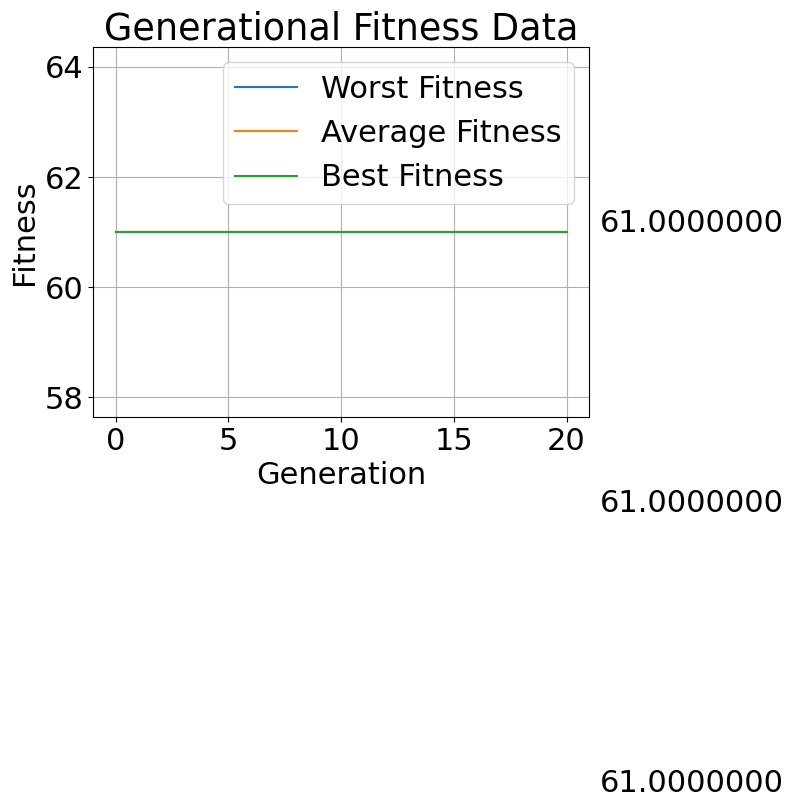

TestType.TRAINING Accuracy: 0.49586776859504134


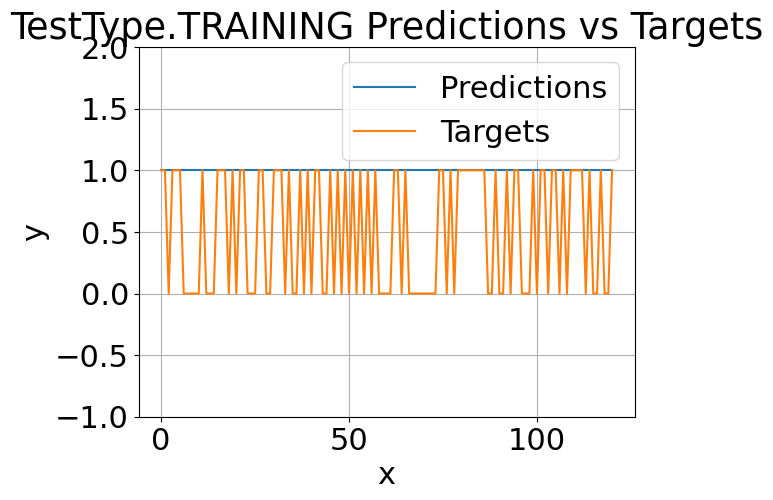

TestType.TEST Accuracy: 0.5471698113207547


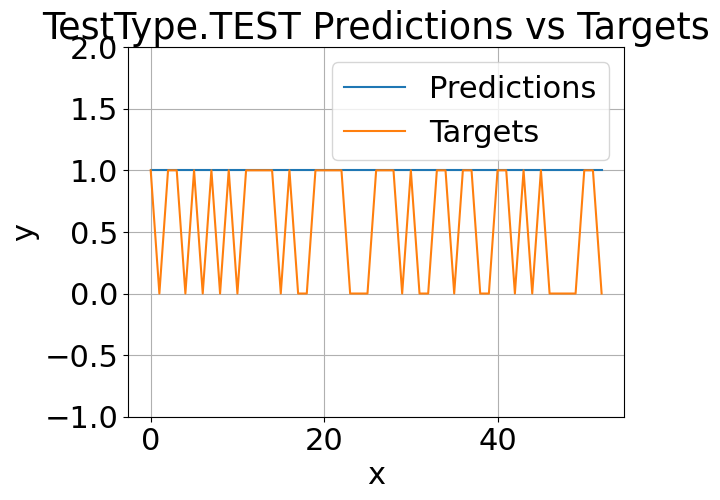

In [33]:
bestGA.PlotGenerationalFitness()

#compare to whole train set
bestGA.Test(x_train, y_train, TestType.TRAINING)
#compare to whole test set outside of bounds
bestGA.Test(x_test, y_test, TestType.TEST)


### NN Verification

In [35]:

#pass weights of best GA's best fit individual to the model
model.set_weights( bestGA.GetBestFitIndividual().genes )

#test accuracy
y_train_pred = model.predict(x_train)[:, 0] #cutoff last dim bc useless
truePreds = np.sum(y_train == y_train_pred)
test_acc = truePreds / y_train.shape[0]

print(f'training accuracy: {test_acc * 100}%')

#test accuracy
y_test_pred = model.predict(x_test)[:, 0] #cutoff last dim bc useless
truePreds = np.sum(y_test == y_test_pred)
test_acc = truePreds / y_test.shape[0]

print(f'test accuracy: {test_acc * 100}%')

4/4 [==============================] - 0s 3ms/step
training accuracy: 49.586776859504134%
2/2 [==============================] - 0s 2ms/step
test accuracy: 54.71698113207547%


## Save GA

In [37]:
save_object(bestGA, "saved_gas/" + "bestGAv1.pkl")

INFO:tensorflow:Assets written to: ram://1e8f2c47-f726-48cb-b043-550bda3c877d/assets


## Restore GA

In [41]:
ga = restore_object("saved_gas/" + "bestGAv1.pkl")

print(ga.testPerformance)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://9271e799-1225-48dd-bc0e-b1d81f8409b4/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

## Save Model

In [ ]:

#pass weights of best GA's best fit individual to the model
model.set_weights( bestGA.GetBestFitIndividual().genes )

model.save("saved_models/fc1_model")

model.summary()

## Restore Model

In [ ]:
model = keras.models.load_model("saved_models/fc1_model")

model.summary()